In [1]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import pickle
import os.path as osp
import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Substitution Plot

In [41]:

BASES = ["A", "C", "G", "T"]
FILE = "/work/Genometechlab/neda/pysamstats_RNA008_csv.csv"

time_s = time.time()

num_valids = 0
num_invalids = 0 
cm_overall = np.zeros((len(BASES), len(BASES)))
perc_overall_sum = np.zeros((len(BASES), len(BASES)))
perc_overall_count = np.zeros((len(BASES), len(BASES)))
for i, chunk in enumerate(pd.read_csv(FILE, sep="\t", chunksize=100000)):
    bases_chunk = chunk[BASES]
    valids = bases_chunk.to_numpy().max(axis=1)>=20
    if sum(valids)==0:
        continue
    ref_chunk = chunk["ref"].to_numpy()[valids]
    read_chunk = chunk[BASES][valids]
    
    pred_chunk = read_chunk.idxmax(axis=1).to_numpy()
    cm_chunk = confusion_matrix(ref_chunk, pred_chunk, labels = BASES)
    cm_overall += cm_chunk

    perc_df = chunk[['ref', *BASES]][valids]
    perc_df_count = perc_df.groupby('ref').count()
    perc_df_sum = perc_df.groupby('ref').sum()
    for i, b in enumerate(BASES):
        try:
            perc_overall_sum[i,:]+=perc_df_sum.loc[b].to_numpy()
            perc_overall_count[i,:]+=perc_df_count.loc[b].to_numpy()
        except:
            pass
    
    num_valids += valids.sum()
    num_invalids += len(chunk)-valids.sum()
time_e = time.time()
print(time_e-time_s)

data_to_save = {"cm": cm_overall, "perc_count": perc_overall_count, 
                "perc_sum": perc_overall_sum,"num_valids": num_valids, "num_invalids": num_invalids}

1126.9504470825195


In [43]:
with open(f"{osp.splitext(FILE)[0]}_cm.pkl", "wb") as f:
    pickle.dump(data_to_save, f)

perc_overall_count = data_to_save['perc_count']
perc_overall_sum = data_to_save['perc_sum']

In [44]:
df = pd.DataFrame(perc_overall_sum/perc_overall_sum.sum(axis=1))
df.columns = BASES
df.index = BASES
df

,A,C,G,T
A,0.992615,0.001289,0.003697,0.002527
C,0.001287,0.992779,0.000893,0.004968
G,0.003994,0.001008,0.993470,0.001329
T,0.002487,0.004282,0.001238,0.992104


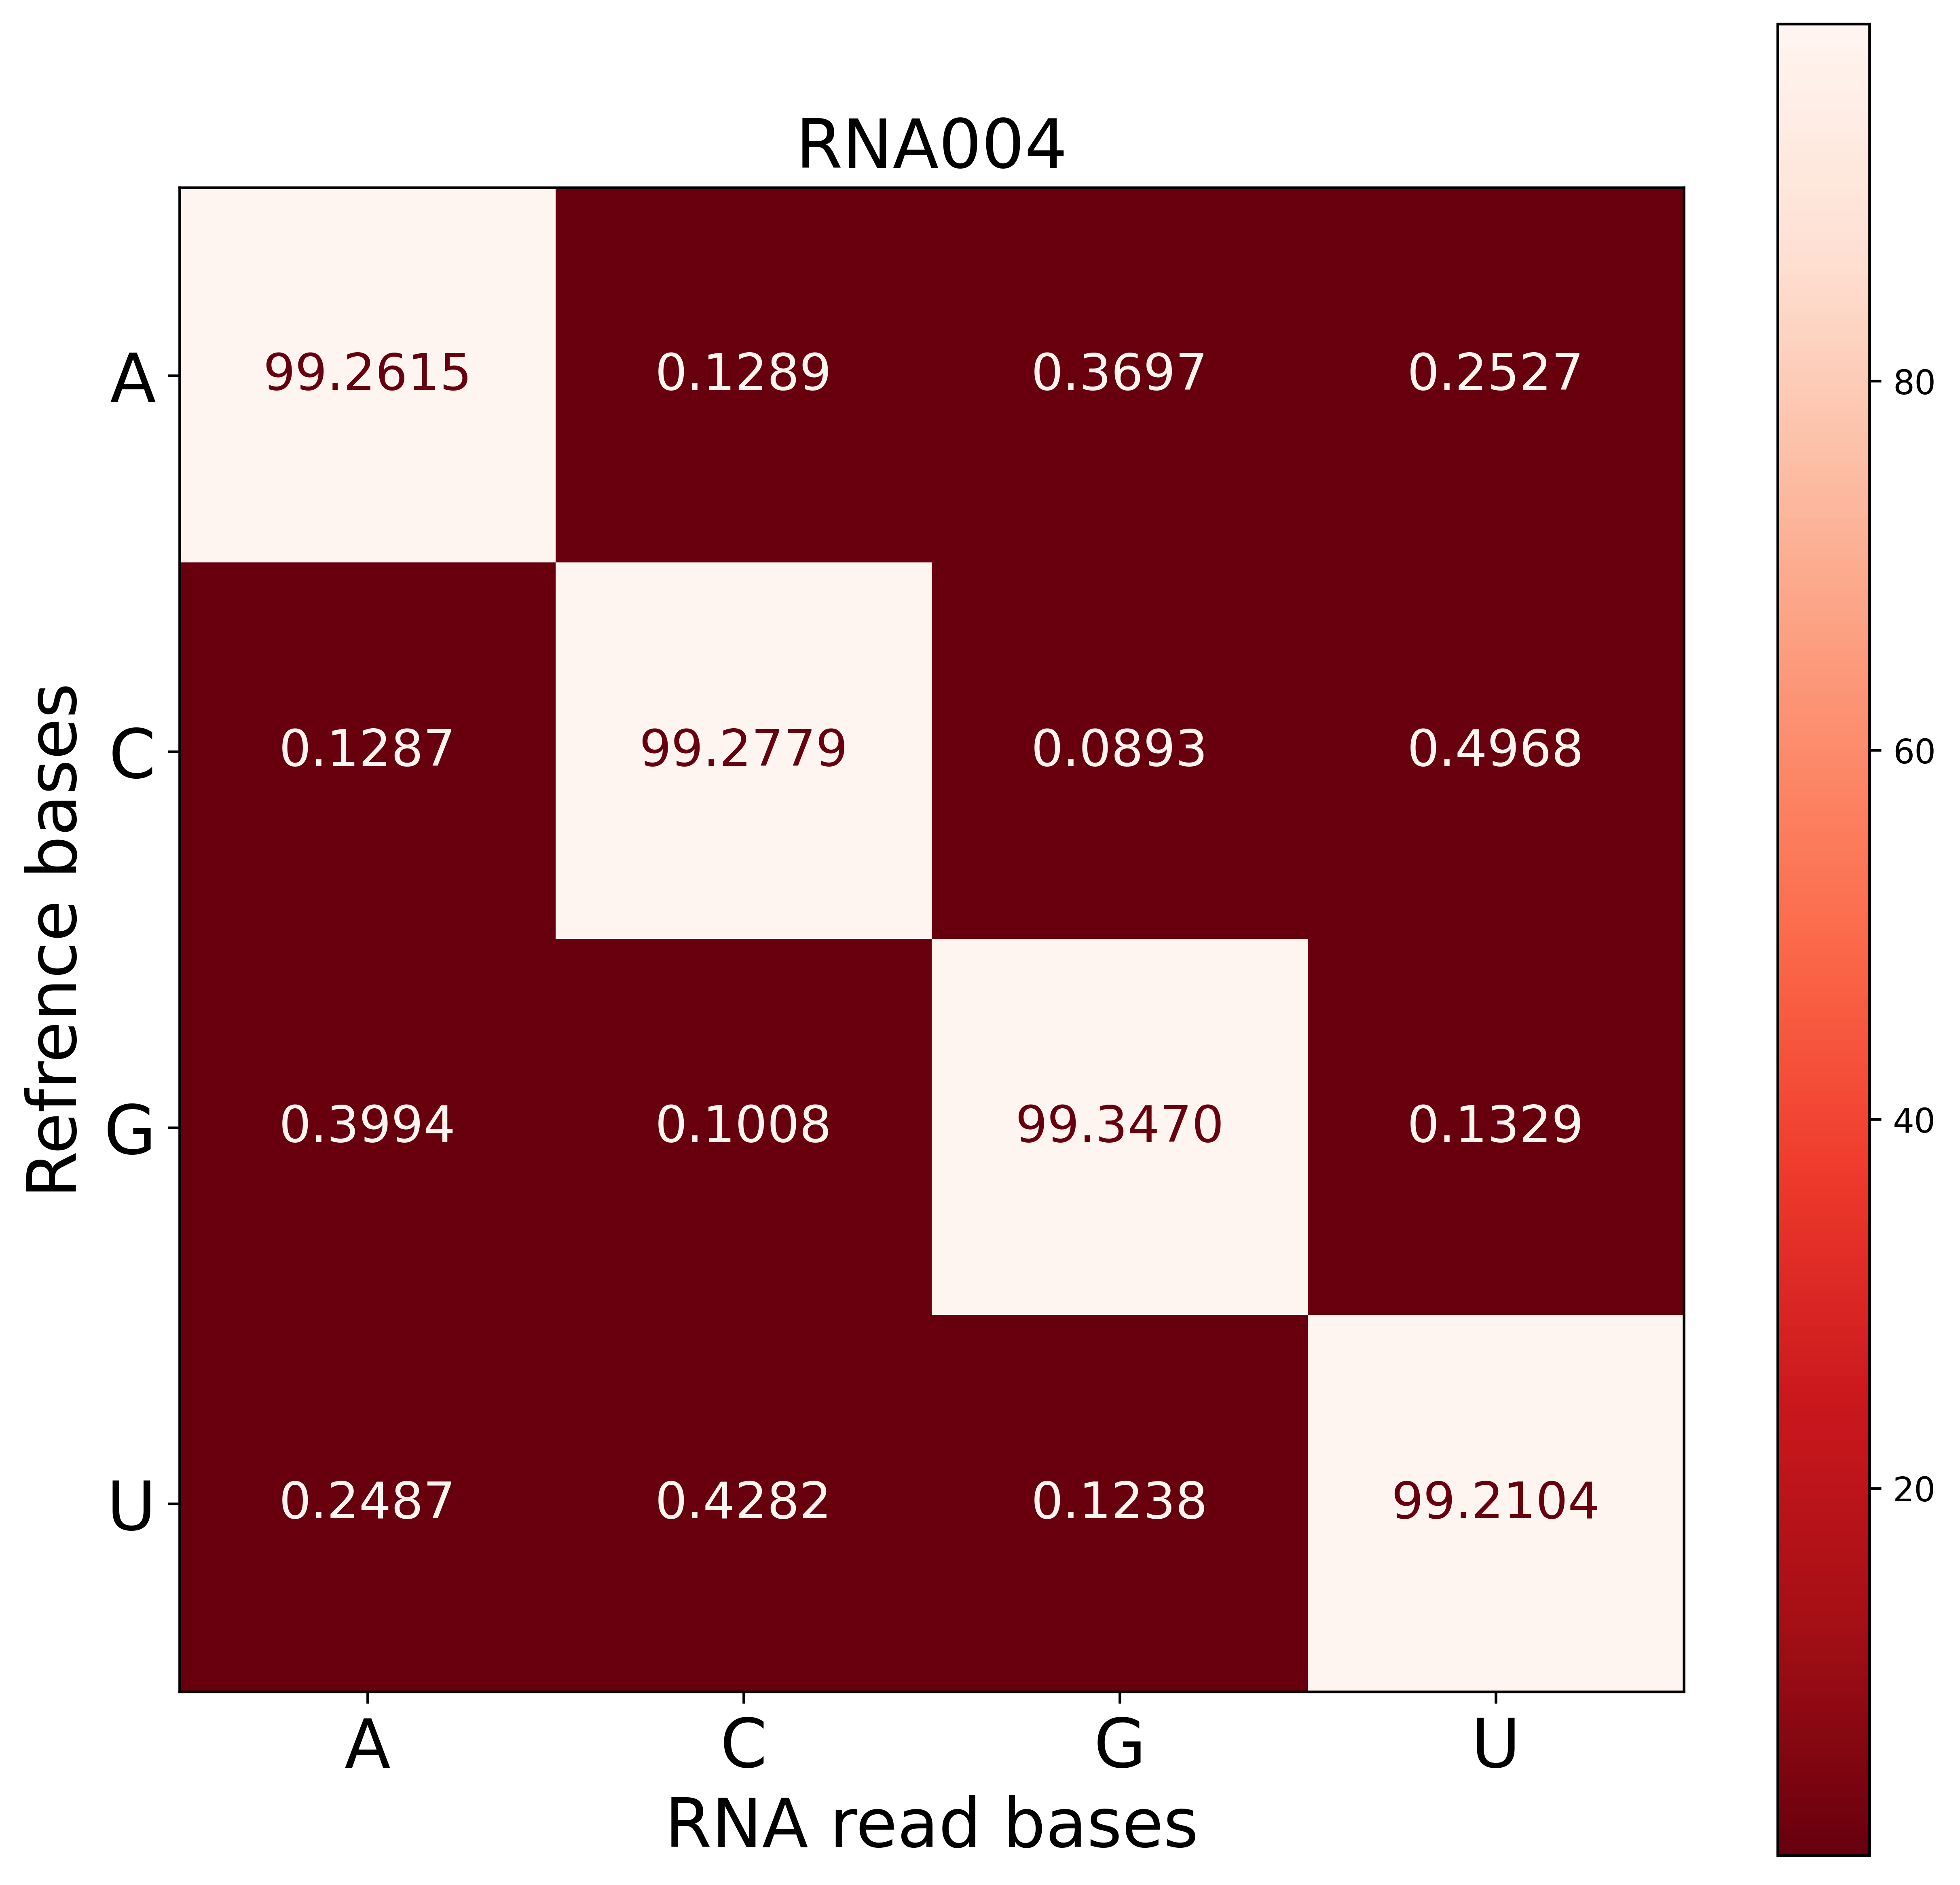

In [45]:
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
fig.set_dpi(600)
cm_plot = ConfusionMatrixDisplay(perc_overall_sum*100/perc_overall_sum.sum(axis=1), display_labels=['A','C','G','U'])
cm_plot.plot(cmap='Reds_r', ax=ax, values_format=".4f")
for text in ax.texts:
    text.set_fontsize(15) 

ax.tick_params(axis='both', which='major', labelsize=20) 
ax.set_title("RNA004", fontsize=20)
ax.set_ylabel("Refrence bases", fontsize=20)
ax.set_xlabel("RNA read bases", fontsize=20)
mpl.rcParams.update({'font.size': 44})
plt.show()